In [ ]:
# The code used for "Inhibitory circuits generate rhythms for leg movements during Drosophila grooming" paper authored by: 
#Durafshan Sakeena Syed, Primoz Ravbar, Julie H Simpson

#This code can be used analyse the segmented behavioral data, including LMM fitting and FDR for comparing datasets, and variability
# estimates.

#Code written by Primoz Ravbar and Durafshan Sakeena Syed (2025) for the paper.

In [1]:
import numpy as np
import scipy
from scipy import ndimage
from scipy import misc
from scipy import linalg
import pickle
import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib.cm as cmap
import matplotlib
import os
import pandas as pd

from scipy.stats import ttest_ind

import math

from numpy import absolute as A
from numpy import transpose as T

import natsort

#import cv2
#import time
import matplotlib.pyplot as plt

import networkx as nx

import umap
import seaborn as sns

import statsmodels.api

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from sklearn.decomposition import NMF

from scipy import signal

from statsmodels.stats.multitest import multipletests

import statsmodels.formula.api as smf
from joblib import Parallel, delayed

In [2]:

# helper functions and feature names:
    
def find_centroids (xdata,ydata,etho_vec):
    
    numb_classes = int(np.max(pr_plot)-np.min(pr_plot))+1
    
    print(numb_classes)
    centroid_table = np.zeros((numb_classes,2))

    for cl in range(0,numb_classes):
        cl_xdata=xdata[etho_vec[:]==cl]
        cl_ydata=ydata[etho_vec[:]==cl]
        
        print(cl)
        print(np.nanmean(cl_xdata),np.nanmean(cl_ydata))

        centroid = [np.nanmean(cl_xdata),np.nanmean(cl_ydata)]
        centroid_table[cl,:] = centroid
        
    return centroid_table   



def merge_clusters(etho_discr, clusters_to_merge):
    
    numb_classes = int(np.max(etho_discr)+1)
    new_cluster = numb_classes + 0

    etho_discr_new = np.copy(etho_discr)

    for cl in clusters_to_merge:

        etho_discr_new[etho_discr[:]==cl]=new_cluster
        
    return etho_discr_new, numb_classes 


feature_name_list = []

for i in range(0,95):
    feature_name_list.append('NA')
    
feature_name_list[0] = "distal-inter-leg-dist"
feature_name_list[1] = "medial-inter-leg-dist"
feature_name_list[2] = "proxy-inter-leg-dist"

feature_name_list[3] = "eu_dist_0"
feature_name_list[4] = "eu_dist_1"
feature_name_list[5] = "eu_dist_2"
feature_name_list[6] = "eu_dist_3"
feature_name_list[7] = "eu_dist_4"
feature_name_list[8] = "eu_dist_5"

feature_name_list[9] = "angle_vel_distal_left"
feature_name_list[10] = "angle_vel_medial_left"
feature_name_list[11] = "angle_vel_distal_right"
feature_name_list[12] = "angle_vel_medial_right"
feature_name_list[13] = "angle_vel_proxy_left"
feature_name_list[14] = "angle_vel_proxy_right"

feature_name_list[15] = "pos_x_0"
feature_name_list[16] = "pos_x_1"
feature_name_list[17] = "pos_x_2"
feature_name_list[18] = "pos_x_3"
feature_name_list[19] = "pos_x_4"
feature_name_list[20] = "pos_x_5"
feature_name_list[21] = "pos_x_6"
feature_name_list[22] = "pos_y_0"
feature_name_list[23] = "pos_y_1"
feature_name_list[24] = "pos_y_2"
feature_name_list[25] = "pos_y_3"
feature_name_list[26] = "pos_y_4"
feature_name_list[27] = "pos_y_5"
feature_name_list[28] = "pos_y_6"

feature_name_list[29] = "whole body velocity"

feature_name_list[30] = "quality control"

feature_name_list[31] = "seg_start"
feature_name_list[32] = "seg_end"

feature_name_list[33] = "segment_duration"

feature_name_list[34] = "lag_9_11"  #DLR
feature_name_list[35] = "lag_10_12"  #MLR
feature_name_list[36] = "lag_13_14" #PLR
feature_name_list[37] = "lag_13_10" #PM-L
feature_name_list[38] = "lag_14_12"   #PM-R
feature_name_list[39] = "lag_10_9"  #MD-L
feature_name_list[40] = "lag_11_12" 

feature_name_list[41] = "bout duration"

feature_name_list[42] = "freq_dist_left"
feature_name_list[43] = "freq_dist_right"
feature_name_list[44] = "freq_med_left"
feature_name_list[45] = "freq_med_right"
feature_name_list[46] = "freq_proxy_left"
feature_name_list[47] = "freq_proxy_right"

####
feature_name_list[48] = "none"
feature_name_list[49] = "none"
feature_name_list[50] = "none"
#feature_name_list[51] = "none"


feature_name_list[51+0] = "max_distal-inter-leg-dist"
feature_name_list[51+1] = "max_medial-inter-leg-dist"
feature_name_list[51+2] = "max_proxy-inter-leg-dist"

feature_name_list[51+3] = "max_eu_dist_0"
feature_name_list[51+4] = "max_eu_dist_1"
feature_name_list[51+5] = "max_eu_dist_2"
feature_name_list[51+6] = "max_eu_dist_3"
feature_name_list[51+7] = "max_eu_dist_4"
feature_name_list[51+8] = "max_eu_dist_5"

feature_name_list[51+9] = "max_angle_vel_distal_left"
feature_name_list[51+10] = "max_angle_vel_medial_left"
feature_name_list[51+11] = "max_angle_vel_distal_right"
feature_name_list[51+12] = "max_angle_vel_medial_right"
feature_name_list[51+13] = "max_angle_vel_proxy_left"
feature_name_list[51+14] = "max_angle_vel_proxy_right"

feature_name_list[51+15] = "max_pos_x_0"
feature_name_list[51+16] = "max_pos_x_1"
feature_name_list[51+17] = "max_pos_x_2"
feature_name_list[51+18] = "max_pos_x_3"
feature_name_list[51+19] = "max_pos_x_4"
feature_name_list[51+20] = "max_pos_x_5"
feature_name_list[51+21] = "max_pos_x_6"
feature_name_list[51+22] = "max_pos_y_0"
feature_name_list[51+23] = "max_pos_y_1"
feature_name_list[51+24] = "max_pos_y_2"
feature_name_list[51+25] = "max_pos_y_3"
feature_name_list[51+26] = "max_pos_y_4"
feature_name_list[51+27] = "max_pos_y_5"
feature_name_list[51+28] = "max_pos_y_6"

feature_name_list[51+29] = "max_whole body velocity"

#feature_name_list[82] = "angle_0" #distal left
#feature_name_list[83] = "angle_1" #medial left
#feature_name_list[84] = "angle_2"
#feature_name_list[85] = "angle_3"
#feature_name_list[86] = "angle_4"
#feature_name_list[87] = "angle_5"

feature_name_list[82] = "left dist angle" #distal left
feature_name_list[83] = "left mid angle" #medial left
feature_name_list[84] = "right dist angle"
feature_name_list[85] = "right mid angle"
feature_name_list[86] = "left proxy angle"
feature_name_list[87] = "right proxy angle"

feature_name_list[88] = "joint_velocity_0"
feature_name_list[89] = "joint_velocity_1"
feature_name_list[90] = "joint_velocity_2"
feature_name_list[91] = "joint_velocity_3"
feature_name_list[92] = "joint_velocity_4"
feature_name_list[93] = "joint_velocity_5"

In [3]:
# Below cells are used to LOAD all the data:

In [6]:
# LOAD segmented features and classification

Name_combined_data = "R11B07GAD_ACR_andControlADDBDEMPTY_ACR"
classifcation_name = "agg_class_UMAP_13_"
Folder_name = 'Z:\\Durafshan\\MOV_raw_data\\Flystusdio\\analysisDLC\\V_elifeR1\\R11B07GAD_ACR_andControlADDBDEMPTY_ACR\\'

with open(Folder_name + "mov_size_list_tot_"+ Name_combined_data , "rb") as f:                            
    mov_size_list_tot = pickle.load(f)  
with open(Folder_name + "animal_ID_list_tot_"+ Name_combined_data , "rb") as f:                            
    animal_ID_list_tot = pickle.load(f)   

with open(Folder_name + "classification_data_dict_" + Name_combined_data + classifcation_name, "rb") as f:                            
    classification_data_dict = pickle.load(f)  
    
pr_plot = classification_data_dict["etho_discr"]    
class_feat_stats = classification_data_dict["class_feat_stats"]  
cont_class = classification_data_dict["etho_cont"]  
umap_emb_ang = classification_data_dict["UMAP_emb"]  
discr_break_point = classification_data_dict["discr_break_point"]  
seg_feat_mat = classification_data_dict["seg_feat_mat"]  
seg_feature_table = classification_data_dict["seg_feature_table"]  

numb_classes = int(np.max(pr_plot)-np.min(pr_plot))+1

# separate groups

numb_classes = int(np.max(pr_plot)-np.min(pr_plot))+1

#cut_1 = contol_end_seg

#cut_1 = 18868 # 13A inhib  #seg. data!! Chrimson control
cut_1 = discr_break_point # 
#cut_2 = cut_1*2
cut_2 = np.shape(seg_feature_table)[1]

#cut_2 = 49279
#cut_1 = 35151
#cut_2 = np.shape(seg_feature_table)[1]

seg_feature_table_g1 = seg_feature_table[:,0:cut_1]
seg_feature_table_g2 = seg_feature_table[:,cut_1:cut_2]

#seg_feature_table_outrem_g1 = seg_feature_table_outrem[:,0:cut_1]
#seg_feature_table_outrem_g2 = seg_feature_table_outrem[:,cut_1:cut_2]

pr_plot_g1 = pr_plot[:,0:cut_1]
pr_plot_g2 = pr_plot[:,cut_1:cut_2]

gr_mem = np.zeros((1,cut_2))
gr_mem[0,0:cut_1] = 0
gr_mem[0,cut_1:cut_2] = 1

gr_mem = gr_mem.flatten()

#for cl in range(0,numb_classes):
    
#    class_feat_stats[50,cl] = np.mean(gr_mem[0,pr_plot[0,0:cut_2]==cl])

#separate movies

mov_time_name_mat = np.zeros((2,np.sum(mov_size_list_tot)))
mov_time_name_table = []

prev_time=0

for ind,seg_size in enumerate(mov_size_list_tot):
    mov_time_name_mat[0,prev_time:prev_time+seg_size]=ind
    prev_time=prev_time+seg_size
    
for i in range(0,np.shape(seg_feature_table)[1]):
    start_seg = int(seg_feature_table[31,i])
    mov_time_name_table.append(mov_time_name_mat[0,start_seg])
    
mov_time_name_table = np.array(mov_time_name_table)



#separate animals

animal_time_name_mat = np.zeros((2,np.sum(mov_size_list_tot)))
animal_time_name_table = []

prev_time=0

for ind,seg_size in enumerate(mov_size_list_tot):
    animal_ID = animal_ID_list_tot[ind]
    animal_time_name_mat[0,prev_time:prev_time+seg_size] = animal_ID
    prev_time=prev_time+seg_size
    
for i in range(0,np.shape(seg_feature_table)[1]):
    start_seg = int(seg_feature_table[31,i])
    animal_time_name_table.append(animal_time_name_mat[0,start_seg])
    
#mov_time_name_table = np.array(mov_time_name_table)

pr_plot = pr_plot.flatten()

In [8]:
print(np.shape(mov_time_name_table))
print(np.shape(gr_mem))
print(np.shape(seg_feature_table))
print(np.shape(pr_plot))
print(np.shape( animal_time_name_table))

(103041,)
(103041,)
(94, 103041)
(103041,)
(103041,)


12
0
-1.2931571448270776 1.152418293420907
1
-0.0644364195954141 -2.155822703795242
2
-3.3552917653062386 1.654108391262296
3
0.3514211616250652 2.6603288921419
4
-1.711822240056301 3.854477379354869
5
0.9776831724633764 0.7566059659441214
6
-1.4112208676598001 -0.8004895957434012
7
1.455691413861129 -0.5258529579103964
8
1.36913653890492 3.911217418156172
9
-0.07069400311627572 -0.4337957291491032
10
2.0845127225949107 2.090512874010049
11
13.334244083350812 1.902623584572698


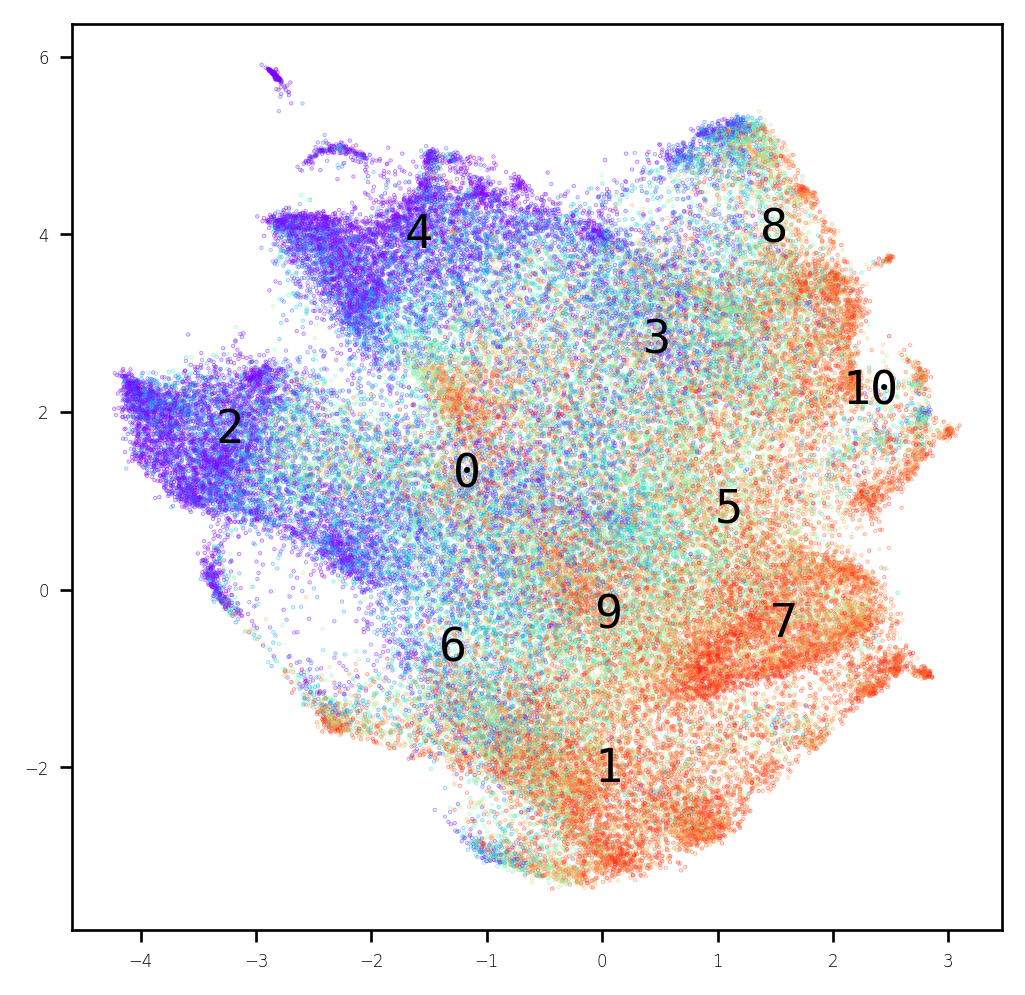

In [9]:

# plot the UMAP of all segments; color segments by phase (in this example) or by other feature, or by class...

fig = plt.figure(figsize=(5, 5), dpi=240)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 5}
matplotlib.rc('font', **font)


list_of_classes = np.unique(pr_plot)
numb_classes = np.size(list_of_classes)

cut_1 = discr_break_point 
cut_2 = cut_1*2

lim1 = 0
lim2 = np.shape(seg_feature_table)[1]

sep_groups = 0

#col_f = seg_feature_table[13,lim1:lim2] #left ampl
#col_f = seg_feature_table[14,lim1:lim2] #right ampl
#col_f = seg_feature_table[0,lim1:lim2] #
#col_f = seg_feature_table[33,lim1:lim2] #SEG duration
col_f = seg_feature_table[36,lim1:lim2] #phase
#col_f = seg_feature_table[29,lim1:lim2] #velocity
#col_f = seg_feature_table[46,lim1:lim2] #freq
#col_f = seg_feature_table[40,lim1:lim2] #BOUT DURATIONS!
#col_f = seg_feature_table[86,lim1:lim2]

#col_f = pr_plot[lim1:lim2] #class membership
#col_f = disc_etho_time_corr[0,lim1:lim2] 
#col_f = disc_etho_time_diff[0,lim1:lim2] 

#col_f = gr_mem[lim1:lim2] #group membership


col_f = np.nan_to_num(col_f)
col = col_f/np.max(col_f)

xdata = np.copy(umap_emb_ang[lim1:lim2,0])
ydata = np.copy(umap_emb_ang[lim1:lim2,1])

xdata_lines = np.copy(umap_emb_ang[:,0])
ydata_lines = np.copy(umap_emb_ang[:,1])

xdata[xdata==0] = np.nan    
ydata[ydata==0] = np.nan  

xdata_lines[xdata_lines==0] = np.nan    
ydata_lines[ydata_lines==0] = np.nan  

centroid_table = find_centroids (xdata,ydata,pr_plot[lim1:lim2])

#cl_excl = [99] #exclude clusters
cl_excl = [11]
#cl_excl = [3]
#cl_excl = [0,3]
#cl_excl = [0,1,4,5,6,7,8,10,11,12,13,14]
#cl_excl = [0,1,3,4,5,6,7,10,11,12,13,14]
#cl_excl = [0,1,3,5,6,7,8,10,11,12,13,14]
#cl_excl = [0,1,3,4,5,6,8,10,11,12,13,14]
#cl_excl = [0,1,10,11,12,13,14] #best for trans classes

#cl_incl = [0,1,10,11,12,13,14] #best for trans classes

#cl_excl=np.arange(0,numb_classes)

#cl_excl = cl_excl[cl_excl != 3] 
#cl_excl=list(cl_excl)
#cl_excl.pop((4,6))
#cl_excl.pop(6)

for c in cl_excl:
    
    xdata[pr_plot[lim1:lim2]==c]=np.nan
    ydata[pr_plot[lim1:lim2]==c]=np.nan
    xdata_lines[pr_plot[:]==c]=np.nan
    ydata_lines[pr_plot[:]==c]=np.nan
    


plt.scatter(xdata, ydata, s=0.3,marker='.', c=col, cmap='rainbow',alpha=0.5)
#plt.scatter(xdata, ydata, s=0.3,marker='.', c=col, cmap='rainbow',alpha=0.5)



for cl in range(0,numb_classes):
    
    if cl_excl.count(cl) == 0:

        plt.text(centroid_table[cl,0], centroid_table[cl,1], str(cl) , color=[0,0,0], fontsize=14,weight=200,fontfamily='monospace')

In [10]:
#SELECT FEATURES
sel1 = np.arange(0, 3)
sel2 = np.arange(9, 15)
sel3 = np.arange(15, 29)
sel4 = np.arange(42, 48)
sel5 = [41]
sel6 = np.arange(60,66)
feature_select = np.hstack((sel1, sel2, sel3, sel4, sel6))
print(feature_select.shape)

(35,)


In [11]:
#SELECT CLASSES
sel_classes = [2,4,7] #13B silencing


In [12]:
# --- LMM Main Script ---

animal_time_name_table = np.array(animal_time_name_table)
gr_mem = np.array(gr_mem)

# Set to False for global FDR, True for per-class FDR
per_class = False

# --- Step 1: Define selected features and syllable classes ---
# Already defined:
# sel_classes = [0, 1, 2, 10, 13]
# feature_select = np.hstack((sel1, sel2, sel3, sel4, sel5, sel6))

print(f"Selected {len(feature_select)} features.")

# --- Step 2: Filter feature data and metadata ---
filtered_seg_feature_table = seg_feature_table[feature_select, :]
valid_idx = np.isin(pr_plot, sel_classes)

filtered_seg_feature_table = filtered_seg_feature_table[:, valid_idx]
filtered_pr_plot = pr_plot[valid_idx]
filtered_animal_time = np.array(animal_time_name_table)[valid_idx]
filtered_gr_mem = np.array(gr_mem)[valid_idx]

# --- Step 3: Build long DataFrame ---
n_valid_features = filtered_seg_feature_table.shape[0]
n_valid_syllables = filtered_seg_feature_table.shape[1]

feature_ids = np.repeat(feature_select, n_valid_syllables)
feature_values = filtered_seg_feature_table.flatten()

df_meta = pd.DataFrame({
    'syllable_id': np.arange(n_valid_syllables),
    'animal': filtered_animal_time,
    'group': filtered_gr_mem,
    'syllable_class': filtered_pr_plot
})

df_long = pd.DataFrame({
    'feature_id': feature_ids,
    'feature_value': feature_values,
    'syllable_id': np.tile(df_meta['syllable_id'].values, n_valid_features),
    'animal': np.tile(df_meta['animal'].values, n_valid_features),
    'group': np.tile(df_meta['group'].values, n_valid_features),
    'syllable_class': np.tile(df_meta['syllable_class'].values, n_valid_features)
})

# --- Step 4: Run LMMs ---
unique_feats = df_long['feature_id'].unique()
unique_classes = df_long['syllable_class'].unique()

def fit_lmm(fid, sc, data):
    sub = data[(data['feature_id'] == fid) & (data['syllable_class'] == sc)]
    if sub['group'].nunique() < 2 or sub['animal'].nunique() < 2:
        return None
    try:
        model = smf.mixedlm("feature_value ~ group", sub, groups=sub["animal"])
        result = model.fit()
        ci_lower, ci_upper = result.conf_int().loc['group']
        return {
            'feature_id': fid,
            'syllable_class': sc,
            'coef': result.params.get("group", np.nan),
            'pval': result.pvalues.get("group", np.nan),
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
        }
    except:
        return None

results = Parallel(n_jobs=-1)(
    delayed(fit_lmm)(fid, sc, df_long)
    for fid in unique_feats for sc in unique_classes
)

df_results = pd.DataFrame([r for r in results if r is not None])

# --- Step 5: FDR Correction ---
if per_class is False:
    pvals = df_results['pval'].values
    mask = ~np.isnan(pvals)
    rejected, pvals_fdr, _, _ = multipletests(pvals[mask], alpha=0.05, method='fdr_bh')

    df_results.loc[mask, 'pval_fdr'] = pvals_fdr
    df_results.loc[mask, 'significant'] = rejected

if per_class is True:
    for cls, group in df_results.groupby('syllable_class'):
        pvals = group['pval'].values
        mask = ~np.isnan(pvals)
        if mask.sum() > 0:
            rejected, pvals_corrected, _, _ = multipletests(pvals[mask], alpha=0.05, method='fdr_bh')
            df_results.loc[group.index[mask], 'pval_fdr'] = pvals_corrected
            df_results.loc[group.index[mask], 'significant'] = rejected

# --- Step 6: Fix NaNs in 'significant' before filtering ---
df_results['significant'] = df_results['significant'].fillna(False)

# --- Step 7: Output summary ---
df_sig = df_results[df_results['significant']].copy()
print(f"Number of significant comparisons: {df_sig.shape[0]}")
print(df_sig.sort_values('pval_fdr')[['feature_id','syllable_class','coef','pval_fdr']])

Selected 35 features.
Number of significant comparisons: 20
    feature_id  syllable_class       coef      pval_fdr
43          47             2.0  -2.171899  2.776837e-16
44          47             4.0  -1.792948  1.321183e-12
40          46             2.0  -1.970258  1.441897e-11
37          45             2.0  -1.294691  7.464860e-11
41          46             4.0  -1.452123  6.167017e-10
39          46             7.0  -2.112621  6.787116e-10
42          47             7.0  -2.042442  1.317646e-07
33          44             7.0  -1.942347  1.290373e-05
31          43             2.0  -0.739967  2.214876e-05
27          42             7.0  -1.251100  2.423535e-05
28          42             2.0  -0.755137  5.057822e-05
30          43             7.0  -1.003936  5.057822e-05
36          45             7.0  -1.804736  1.240657e-04
38          45             4.0  -0.796613  1.281902e-04
34          44             2.0  -0.934879  2.123914e-04
35          44             4.0  -0.786946  9

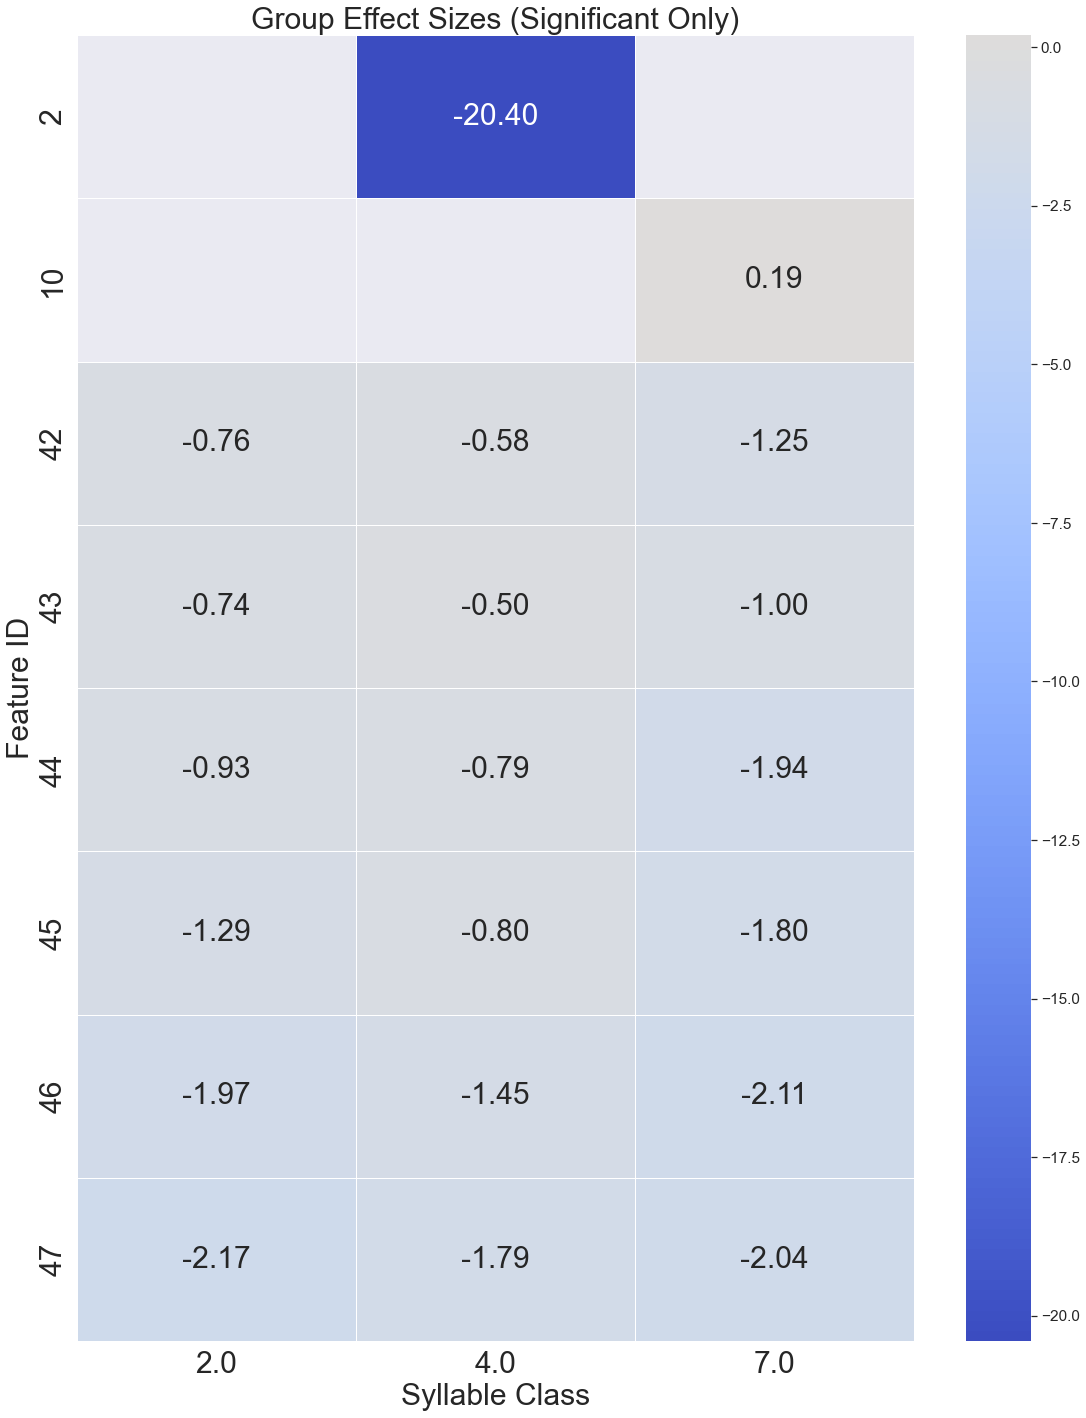

In [13]:


df_sig = df_results[df_results['significant']].copy()
# Prepare pivot table
heatmap_data = df_sig.pivot(index='feature_id', columns='syllable_class', values='coef')

# Set font scale for larger labels and annotation text
sns.set(font_scale=1.4)  # Increase overall font size

# Create heatmap
plt.figure(figsize=(16, 20))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.9,
    annot_kws={"size": 30}  # Larger annotation text inside heatmap cells
)
plt.title("Group Effect Sizes (Significant Only)", fontsize=30)
plt.xlabel("Syllable Class", fontsize=30)
plt.ylabel("Feature ID", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.show()

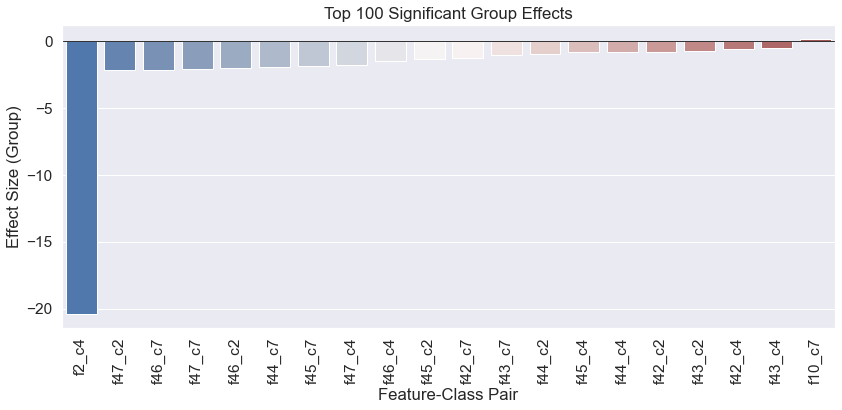

In [14]:
# Top N effects sorted by absolute effect size
top_n = 100
df_top = df_sig.copy()
df_top['abs_coef'] = df_top['coef'].abs()
df_top = df_top.sort_values('abs_coef', ascending=False).head(top_n)

# Create labels
df_top['label'] = df_top.apply(lambda row: f"f{int(row.feature_id)}_c{int(row.syllable_class)}", axis=1)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_top, x='label', y='coef', palette='vlag')
plt.xticks(rotation=90)
plt.title(f"Top {top_n} Significant Group Effects")
plt.xlabel("Feature-Class Pair")
plt.ylabel("Effect Size (Group)")
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

In [15]:
def plot_feature_group_comparison(df_long, df_results, feature_id, syllable_class, figsize=(6, 5)):
    """
    Plots per-animal mean feature values by group with significance annotation from LMM,
    including both uncorrected and FDR-corrected p-values.
    """
    feature_label = feature_name_list[feature_id]  # Get feature name from list

    # Subset data
    df_sub = df_long[
        (df_long['feature_id'] == feature_id) & 
        (df_long['syllable_class'] == syllable_class)
    ]

    # Compute per-animal means
    df_animal = df_sub.groupby(['animal', 'group'])['feature_value'].mean().reset_index()

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(data=df_animal, x='group', y='feature_value', ci=95, capsize=0.2, errwidth=1.5)
    sns.stripplot(data=df_animal, x='group', y='feature_value', color='black', size=8, alpha=0.7)

    # LMM significance info
    result_row = df_results[
        (df_results['feature_id'] == feature_id) & 
        (df_results['syllable_class'] == syllable_class)
    ]

    if not result_row.empty:
        pval_raw = result_row['pval'].values[0]
        pval_fdr = result_row['pval_fdr'].values[0]
        is_significant = result_row['significant'].values[0]

        # Draw annotation bar
        y_max = df_animal['feature_value'].max()
        x1, x2 = 0, 1
        bar_y = y_max + 0.05 * abs(y_max)
        h = 0.01 * abs(y_max)
        ax.plot([x1, x1, x2, x2], [bar_y, bar_y + h, bar_y + h, bar_y], lw=2, color='black')

        # Format p-values
        p_text = (
            f"p = {pval_raw:.3g}, p_FDR = {pval_fdr:.3g}"
            if not np.isnan(pval_fdr)
            else f"p = {pval_raw:.3g}"
        )

        # Show text annotation
        ax.text((x1 + x2) / 2, bar_y + h + h/2, p_text, ha='center', va='bottom', fontsize=14, color='black')

    ax.set_title(f"{feature_label} — Syllable Class {int(syllable_class)}", fontsize=20)
    ax.set_xlabel("Group", fontsize=18)
    ax.set_ylabel(f"Mean {feature_label} (per animal)", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    plt.show()

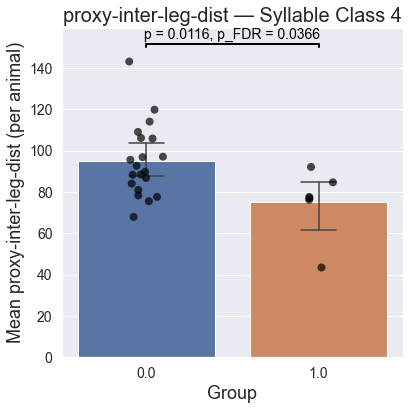

In [16]:
# EXAMPLE feature_id = 2; syllable_class = 4

plot_feature_group_comparison(df_long, df_results,2,4, figsize=(6, 6))

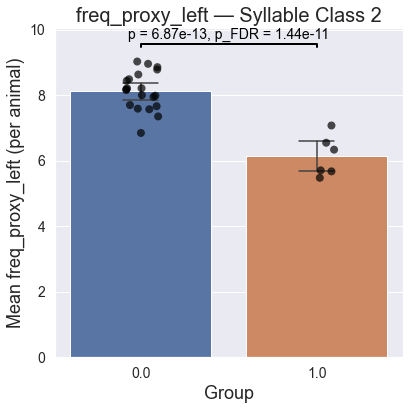

In [17]:

# EXAMPLE feature_id = 46; syllable_class = 2

plot_feature_group_comparison(df_long, df_results, 46, 2, figsize=(6, 6))

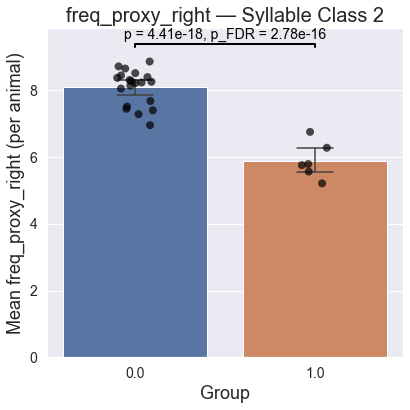

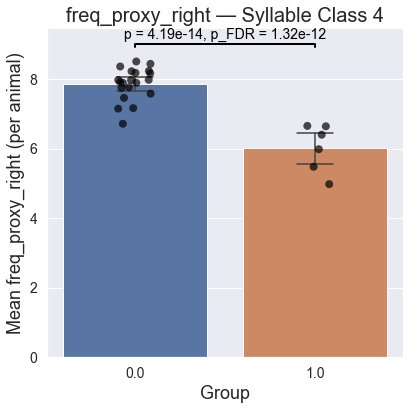

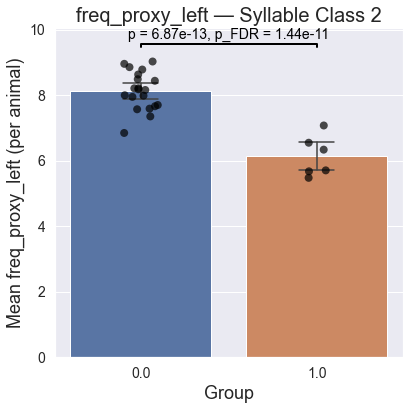

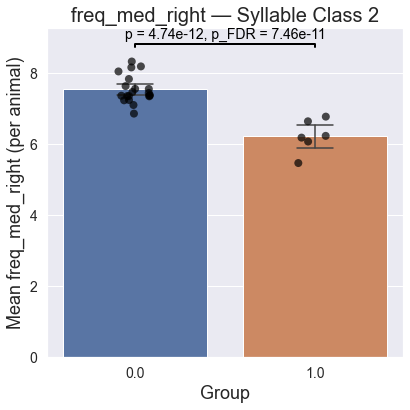

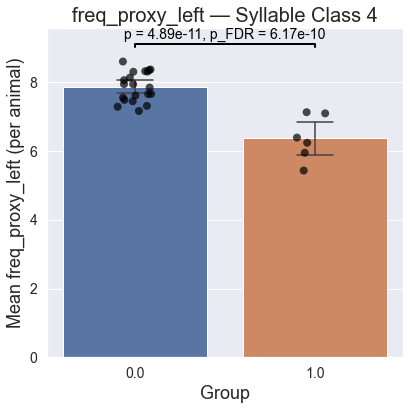

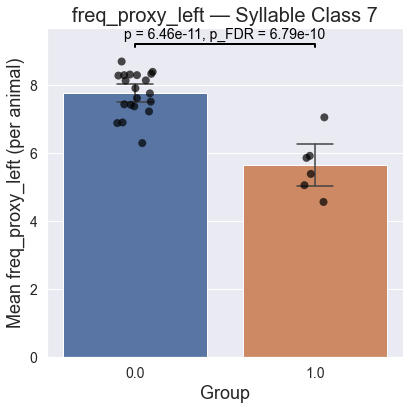

In [18]:

# plot TOP n_top most significant results (after LMM and FDR)

n_top = 6

top = df_results.nsmallest(n_top, "pval")
for _, row in top.iterrows():
    plot_feature_group_comparison(df_long, df_results, int(row['feature_id']), int(row['syllable_class']), figsize=(6, 6))

In [19]:
#variabilities MAIN CODE (this is to compare variabilities of features and classes)

def compute_variability_stats(
    seg_feature_table, pr_plot, animal_time_name_table, gr_mem,
    feature_select, sel_classes
):
    # --- Step 1: Prepare inputs ---
    features = seg_feature_table[feature_select]  # shape: (F, N)
    syllable_classes = np.asarray(pr_plot)
    animal_ids = np.asarray(animal_time_name_table)
    group_ids = np.asarray(gr_mem)

    F, N = features.shape
    selected_class_set = set(sel_classes)

    # --- Step 2: Collect per-animal std values ---
    records = []

    for f_idx, feature_id in enumerate(feature_select):
        for cls in sel_classes:
            # mask for current class
            mask = syllable_classes == cls
            if not np.any(mask):
                continue

            feat_vals = features[f_idx, mask]
            animals = animal_ids[mask]
            groups = group_ids[mask]

            df = pd.DataFrame({
                'animal': animals,
                'value': feat_vals,
                'group': groups
            })

            # compute std per animal
            per_animal_std = df.groupby(['animal', 'group'])['value'].std().reset_index()

            if per_animal_std['value'].isna().all():
                continue  # skip if all NaNs (e.g., only one sample per animal)

            per_animal_std['feature'] = feature_id
            per_animal_std['syllable_class'] = cls
            records.append(per_animal_std)

    # --- Step 3: Combine all and run t-tests ---
    df_all = pd.concat(records, ignore_index=True)
    results = []

    for (f_id, cls), group_df in df_all.groupby(['feature', 'syllable_class']):
        g0 = group_df[group_df['group'] == 0]['value'].dropna()
        g1 = group_df[group_df['group'] == 1]['value'].dropna()

        if len(g0) < 2 or len(g1) < 2:
            continue  # skip unreliable comparisons

        stat, pval = ttest_ind(g0, g1, equal_var=False)

        results.append({
            'feature': f_id,
            'syllable_class': cls,
            'n_group0': len(g0),
            'n_group1': len(g1),
            'std_mean_group0': g0.mean(),
            'std_mean_group1': g1.mean(),
            'tstat': stat,
            'pval': pval
        })

    df_results = pd.DataFrame(results)

    # --- Step 4: FDR correction ---
    if not df_results.empty:
        df_results['pval_fdr'] = np.nan
        df_results['significant'] = False

        pvals = df_results['pval'].values
        mask = ~np.isnan(pvals)
        rej, pvals_fdr, _, _ = multipletests(pvals[mask], method='fdr_bh')

        df_results.loc[mask, 'pval_fdr'] = pvals_fdr
        df_results.loc[mask, 'significant'] = rej
        
        df_all = pd.concat(records, ignore_index=True) if records else pd.DataFrame()
    return df_results, df_all

    #return df_results

In [20]:
df_results, df_all = compute_variability_stats(
    seg_feature_table,
    pr_plot,
    animal_time_name_table,
    gr_mem,
    feature_select,
    sel_classes
)

In [21]:
def plot_feature_variability_comparison(df_all, df_results, feature_id, syllable_class, feature_name_list, figsize=(6, 5)):
    """
    Plots per-animal feature std (variability) by group with significance annotation from t-tests,
    including both uncorrected and FDR-corrected p-values.
    """
    feature_label = feature_name_list[feature_id]

    # Subset data
    df_sub = df_all[
        (df_all['feature'] == feature_id) & 
        (df_all['syllable_class'] == syllable_class)
    ]

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(data=df_sub, x='group', y='value', ci=95, capsize=0.2, errwidth=1.5)
    sns.stripplot(data=df_sub, x='group', y='value', color='black', size=8, alpha=0.7)

    # Significance annotation
    result_row = df_results[
        (df_results['feature'] == feature_id) &
        (df_results['syllable_class'] == syllable_class)
    ]

    if not result_row.empty:
        pval_raw = result_row['pval'].values[0]
        pval_fdr = result_row['pval_fdr'].values[0]
        is_significant = result_row['significant'].values[0]

        # Draw annotation bar
        y_max = df_sub['value'].max()
        x1, x2 = 0, 1
        bar_y = y_max + 0.05 * abs(y_max)
        h = 0.01 * abs(y_max)
        ax.plot([x1, x1, x2, x2], [bar_y, bar_y + h, bar_y + h, bar_y], lw=2, color='black')

        # Format p-values
        p_text = (
            f"p = {pval_raw:.3g}, p_FDR = {pval_fdr:.3g}"
            if not np.isnan(pval_fdr)
            else f"p = {pval_raw:.3g}"
        )

        # Show text annotation
        ax.text((x1 + x2) / 2, bar_y + h + h/2, p_text, ha='center', va='bottom', fontsize=14, color='black')

    ax.set_title(f"{feature_label} — Syllable Class {int(syllable_class)}", fontsize=20)
    ax.set_xlabel("Group", fontsize=18)
    ax.set_ylabel(f"STD of {feature_label} (per animal)", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    plt.show()
    
    
def batch_plot_variability(
    df_all, df_results, feature_ids, syllable_classes, feature_name_list,
    ncols=4, figsize_per_plot=(6, 5)
):
    nrows = (len(feature_ids) * len(syllable_classes) + ncols - 1) // ncols
    figsize = (figsize_per_plot[0] * ncols, figsize_per_plot[1] * nrows)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    
    for idx_f, feature_id in enumerate(feature_ids):
        for idx_c, syll_class in enumerate(syllable_classes):
            ax = axes[(idx_f * len(syllable_classes) + idx_c) // ncols,
                      (idx_f * len(syllable_classes) + idx_c) % ncols]

            # Subset data
            df_sub = df_all[
                (df_all['feature'] == feature_id) & 
                (df_all['syllable_class'] == syll_class)
            ]

            if df_sub.empty:
                ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=14)
                ax.set_title(f"Feature {feature_id} - Class {syll_class}")
                ax.axis('off')
                continue

            sns.barplot(data=df_sub, x='group', y='value', ci=95, capsize=0.2, errwidth=1.5, ax=ax)
            sns.stripplot(data=df_sub, x='group', y='value', color='black', size=6, alpha=0.7, ax=ax)

            # Get significance info
            result_row = df_results[
                (df_results['feature'] == feature_id) & 
                (df_results['syllable_class'] == syll_class)
            ]

            if not result_row.empty:
                pval_raw = result_row['pval'].values[0]
                pval_fdr = result_row['pval_fdr'].values[0]

                y_max = df_sub['value'].max()
                x1, x2 = 0, 1
                bar_y = y_max + 0.05 * abs(y_max)
                h = 0.01 * abs(y_max)
                ax.plot([x1, x1, x2, x2], [bar_y, bar_y + h, bar_y + h, bar_y], lw=1.5, color='black')

                p_text = (
                    f"p = {pval_raw:.3g}, p_FDR = {pval_fdr:.3g}"
                    if not np.isnan(pval_fdr)
                    else f"p = {pval_raw:.3g}"
                )
                ax.text((x1 + x2) / 2, bar_y + h + h/2, p_text, ha='center', va='bottom', fontsize=10)

            feat_label = feature_name_list[feature_id] if feature_id < len(feature_name_list) else f"Feature {feature_id}"
            ax.set_title(f"{feat_label} — Class {syll_class}", fontsize=12)
            ax.set_xlabel("Group", fontsize=10)
            ax.set_ylabel("STD (per animal)", fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=9)

    # Remove empty subplots if any
    total_plots = len(feature_ids) * len(syllable_classes)
    for i in range(total_plots, nrows * ncols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()    

In [33]:
# below plot variability comparisons for features and classes

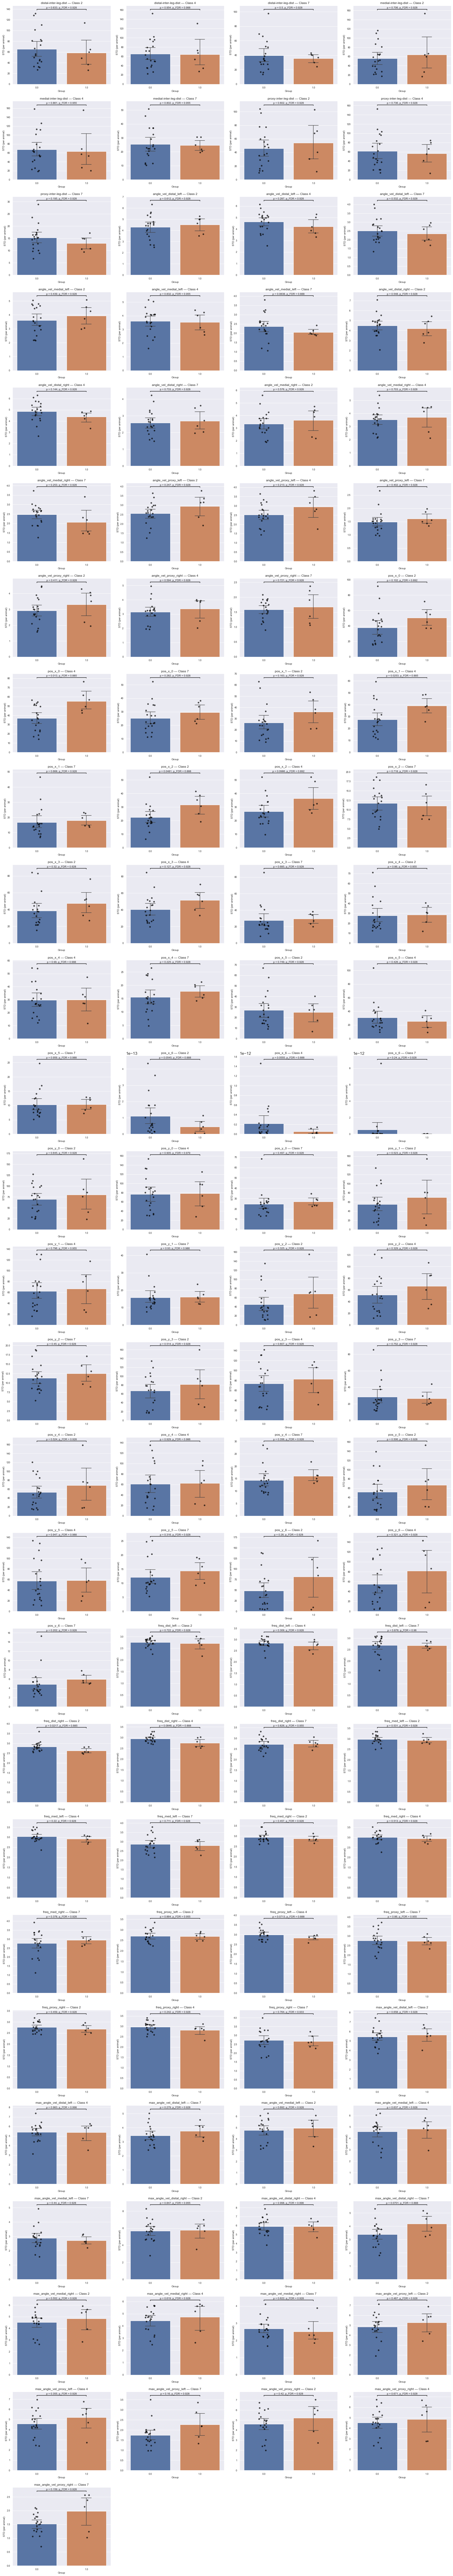

In [22]:
batch_plot_variability(
    df_all=df_all,
    df_results=df_results,
    feature_ids=feature_select,
    syllable_classes=sel_classes,
    feature_name_list=feature_name_list,
    ncols=4,
    figsize_per_plot=(6, 5)
)